In [3]:
from itertools import count
import numpy as np
import pandas as pd
import psycopg2
import dotenv
import os
from matplotlib import animation
from matplotlib import pyplot as plt
from mplsoccer import Pitch
from scipy.interpolate import interp1d

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)


matches_1 = """
SELECT  
    me.*, 
    et.name AS event_name,  
    et.description AS event_description  
FROM public.matchevents me
INNER JOIN public.eventtypes et USING(eventtype_id)
INNER JOIN public.matches m USING(match_id)
WHERE m.match_id = '5pcyhm34h5c948yji4oryevpw'
"""

df_matches = pd.read_sql_query(matches_1,conn)


# Convert timedelta-like format to seconds
df_matches["timestamp"] = df_matches["timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)
df_matches["end_timestamp"] = df_matches["end_timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)

# Check the result
print(df_matches[["timestamp", "end_timestamp"]].head())


df_matches.head()

   timestamp  end_timestamp
0      0.087          1.627
1      1.627          4.178
2      4.178            NaN
3      6.575            NaN
4      6.576            NaN


,match_id,event_id,eventtype_id,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,x,y,end_coordinates_x,end_coordinates_y,receiver_player_id,event_name,event_description
0,5pcyhm34h5c948yji4oryevpw,2704102295,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0.087,1.627,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,6g9x1y7xmjzwhk646v1iyuup5,50.0,50.0,37.0,49.3,cfxzvlgvt9jj17qxq41t9sxcl,PASS,StatsPerform/Opta event type: PASS
1,5pcyhm34h5c948yji4oryevpw,2704102881,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,1.627,4.178,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,cfxzvlgvt9jj17qxq41t9sxcl,39.1,48.0,32.3,38.9,2ky2kn7gpjorkyg9zyg68pk6i,PASS,StatsPerform/Opta event type: PASS
2,5pcyhm34h5c948yji4oryevpw,2704102909,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,INCOMPLETE,False,1,4.178,NaN,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,2ky2kn7gpjorkyg9zyg68pk6i,36.3,36.4,69.7,16.7,None,PASS,StatsPerform/Opta event type: PASS
3,5pcyhm34h5c948yji4oryevpw,2704103595,2464af85-9671-4c4c-90ae-100af0a5e2ee,WON,True,1,6.575,NaN,alive,cyrrlv6l1onld5x247w1q1jlr,bw9wm8pqfzcchumhiwdt2w15c,9fvwcsajeousbo5o0e84cj2sp,22.0,91.6,NaN,NaN,None,DUEL,StatsPerform/Opta event type: DUEL
4,5pcyhm34h5c948yji4oryevpw,2704103597,2464af85-9671-4c4c-90ae-100af0a5e2ee,LOST,False,1,6.576,NaN,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,8ozlo6qrdavr86guhclwvh84q,78.0,8.4,NaN,NaN,None,DUEL,StatsPerform/Opta event type: DUEL


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode event names to numerical values
label_encoder = LabelEncoder()
df_matches["event_label"] = label_encoder.fit_transform(df_matches["event_name"])

# Remove rows with NaN values
df_matches_clean = df_matches.dropna(subset=["timestamp", "event_label"])

# Define features (X) and target variable (y)
X = df_matches_clean[["timestamp"]].values
y = df_matches_clean["event_label"].values

# Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict event types over time
y_pred = model.predict(X_test)

# Check model performance
print(f"Model Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")


Model Coefficients: [0.01071403]
Model Intercept: 16.228005200415687


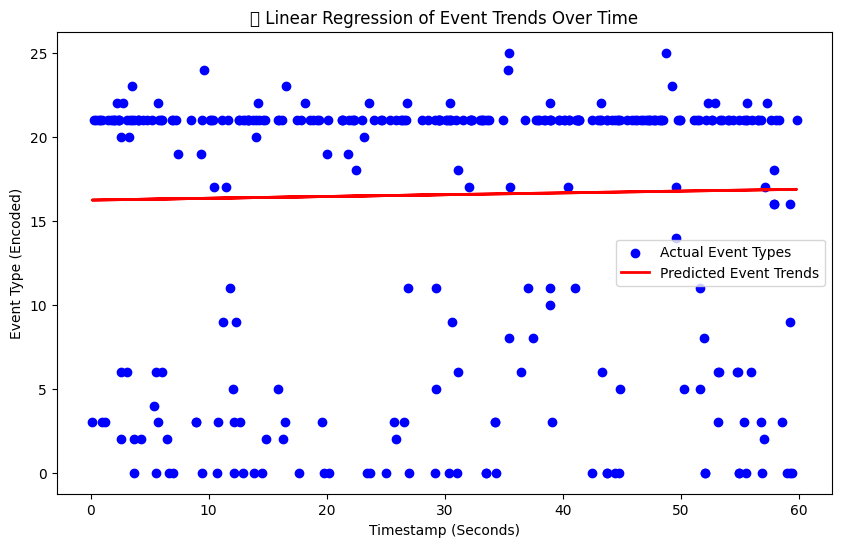

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="blue", label="Actual Event Types")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Predicted Event Trends")
plt.xlabel("Timestamp (Seconds)")
plt.ylabel("Event Type (Encoded)")
plt.title("📊 Linear Regression of Event Trends Over Time")
plt.legend()
plt.show()
